# **Neural Networks For Classification**

---

## Overview

###  Student Information
Full name: Le Ngoc Anh Khoa \
Student ID: 22127196

---

## Implementation

### Import Neccessary Libraries

**Check the framework version**

In [1]:
# Main framework for the project
import sklearn as sk
import torch
import tensorflow as tff

# Check the version of the libraries
print("sklearn version: ", sk.__version__)
print("torch version: ", torch.__version__)
print("tensorflow version: ", tff.__version__)

sklearn version:  1.6.0
torch version:  2.5.1+cu121
tensorflow version:  2.17.1


**Import other neccessary libraries**

In [2]:
# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for data loading
import pickle
import tarfile

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Library for time measuring
import time

### Data Preparation

**Load the data**

Load the data from downloaded file.

In [3]:
# Load CIFAR-10 dataset
def load_cifar10():
    (X_train, y_train), (X_test, y_test) = tff.keras.datasets.cifar10.load_data()

    return X_train, y_train, X_test, y_test

# Load label names (CIFAR-10 fixed class names)
def load_label_names():
    return [
        "airplane", "automobile", "bird", "cat",
        "deer", "dog", "frog", "horse", "ship", "truck"
    ]

# Load the dataset
X_train, y_train, X_test, y_test = load_cifar10()

# Load the class names
label_names = load_label_names()

# Print dataset information
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

# Print CIFAR-10 class names
print("\nCIFAR-10 Class Names:")
for idx, name in enumerate(label_names):
    print(f"{idx}: {name}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)

CIFAR-10 Class Names:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


**Check if any missing values exist**

In [ ]:
# Check if any missing values in the data
print("Missing values in training data:", np.isnan(X_train).sum())

# Count features of the data
print("Number of features:", X_train.shape[1])

# Check the data type of the features
print("Data type of the features:", X_train.dtype)

# Print the unique classes in the training labels
print("Unique classes in the training labels:", np.unique(y_train))

Missing values in training data: 0
Number of features: 32
Data type of the features: uint8
Unique classes in the training labels: [0 1 2 3 4 5 6 7 8 9]


**Check the distribution of each label**

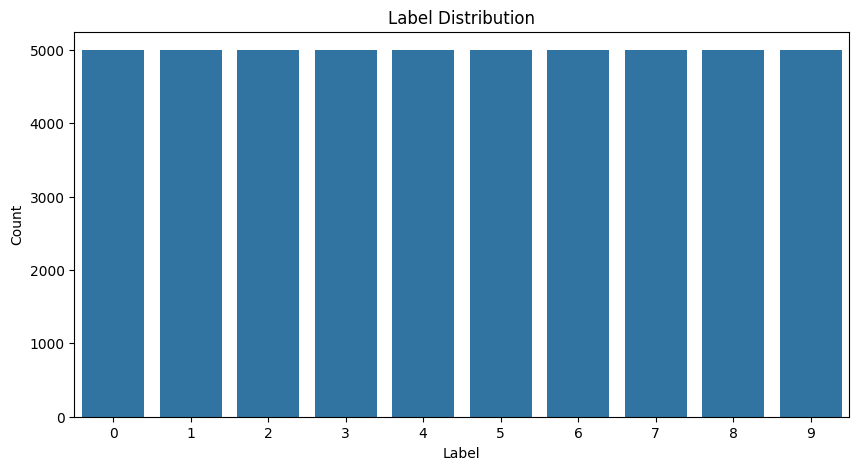

In [ ]:
# Convert y_train to 1D array
y_train_1d = y_train.reshape(-1)

# Create a countplot of the label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_1d)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The distribution is good.

**Visualize 100 images in train set** \
Select 100 images randomly from the train set and plot them for visualization.

(-0.5, 319.5, 319.5, -0.5)

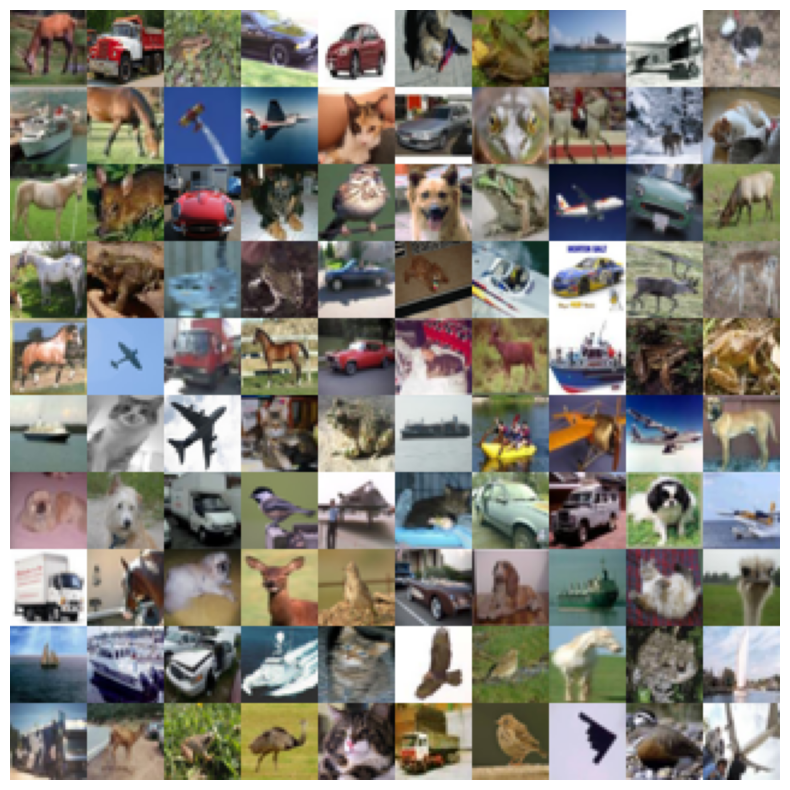

In [ ]:
# Visualize the data
images = X_train

# Randomly select 100 images
idx = np.random.choice(np.arange(50000), 100, replace=False)

# Create a canvas for visualization
canvas = np.zeros((32*10, 32*10, 3), dtype=np.uint8)

for i in range(10):
    for j in range(10):
        canvas[i*32:(i+1)*32, j*32:(j+1)*32] = images[idx[i*10+j]]

plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.axis('off')

**Use preprocessor of scikit-learn to do data preprocessing** \
With this dataset, standardlization is a good choice for preprocessing

In [4]:
# Flattern the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardlize the data
scaler = StandardScaler()
X_train_scale_flat = scaler.fit_transform(X_train_flat)
X_test_scale_flat = scaler.transform(X_test_flat)

# Keep the scale data for visualization (will be used later)
X_train_scale = X_train_scale_flat.reshape(X_train_scale_flat.shape[0], 32, 32, 3)
X_test_scale = X_test_scale_flat.reshape(X_test_scale_flat.shape[0], 32, 32, 3)

# Print the shape of the data
# Print shape
print("Training data shape after flattening:", X_train_scale_flat.shape)
print("Testing data shape after flattening:", X_test_scale_flat.shape)

# Print the maximum and minumum value of X_train after scaling
print("Maximum value of X_train after scaling:", np.max(X_train_scale_flat))
print("Minimum value of X_train after scaling:", np.min(X_train_scale_flat))

Training data shape after flattening: (50000, 3072)
Testing data shape after flattening: (10000, 3072)
Maximum value of X_train after scaling: 2.625075032925612
Minimum value of X_train after scaling: -2.207429023795172


**Visualize 100 images selected after scaling**

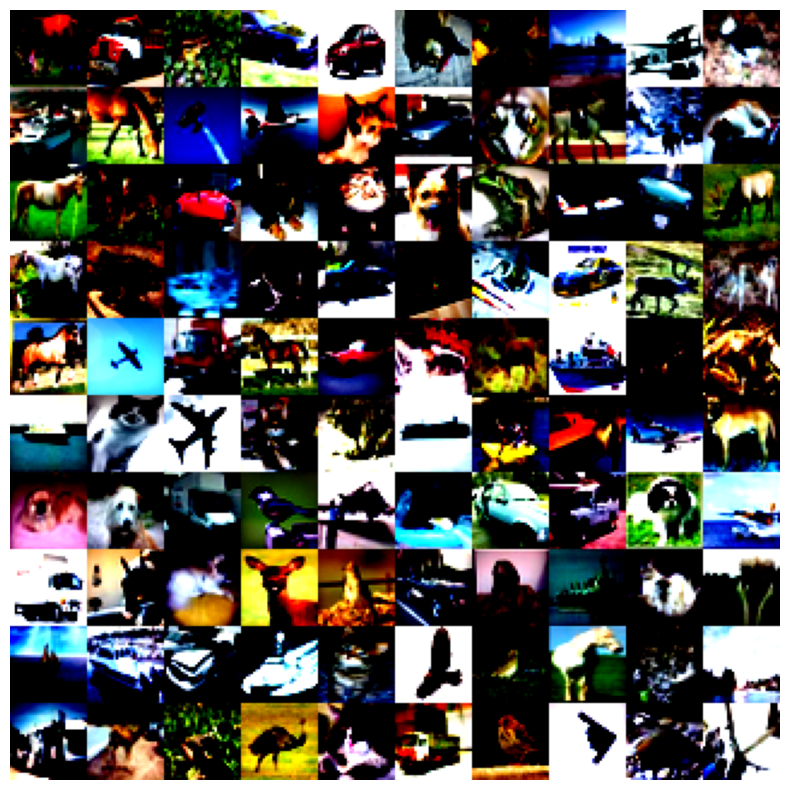

In [ ]:
# print the images after scaling
images = X_train_scale

# Create a canvas for visualization
canvas = np.zeros((32 * 10, 32 * 10, 3), dtype=np.float32)  # Use float32 for [0, 1] range
for i in range(10):
    for j in range(10):
        canvas[i * 32:(i + 1) * 32, j * 32:(j + 1) * 32] = images[idx[i * 10 + j]]

# Display the canvas with images in [0, 1]
plt.figure(figsize=(10, 10))
plt.imshow(canvas)  # No need to multiply by 255
plt.axis('off')
plt.show()

### Model Design

For selecting the best hyperparameters for this project, I employed hyperparameter tuning to identify the optimal configuration based on the `validation dataset's accuracy` and `training dataset's accuracy` which is splitted below.

In this section, I used `TensorFlow` to compile and train the model, as it is the fastest framework available (based on my knowledge).



**Split dataset into train set and validation set for designing model**

In [ ]:
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_train_scale_flat, y_train, test_size=0.2, random_state=42)

  **Hyperparameter tuning for model architecture**
  - With hidden layers:
    - largest number of layers is 3 (since the time is limit)
    - largest neurons of a layer is 1024 (since the time is limit)
  - With activations, I just choose 3 basic activations include: relu, tanh and sigmoid
  - Batch size: 3 options are 64, 128, 256

In [ ]:
# Import tensorflow modules to design the MLP model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Hyperparameters for tuning
layers = [[512], [1024], [512, 256], [1024, 512, 256]]
activations = ['ReLU', 'Tanh', 'Sigmoid']  # Correct activation names
batch_sizes = [64, 128, 256]
epochs = 10  # Number of epochs for tuning
learning_rate = 0.001  # Learning rate (just for tuning)

# Create a dictionary to store the results
results = {
    'layers': [],
    'activation': [],
    'batch_size': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'elapsed_time': []
}

# Function to calculate accuracy for torch model
def calculate_accuracy(loader, model):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for inputs, label in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.numpy())
            labels.extend(label.numpy())
    return accuracy_score(labels, preds)

# Hyperparameters for tuning
layers = [[512], [1024], [512, 256], [1024, 512, 256]]
activations = ['relu', 'tanh', 'sigmoid']  # Activation names for TensorFlow
batch_sizes = [64, 128, 256]
epochs = 10  # Number of epochs for tuning
learning_rate = 0.001  # Learning rate (just for tuning)

# Create a dictionary to store the results
results = {
    'layers': [],
    'activation': [],
    'batch_size': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'elapsed_time': []
}

# Loop through hyperparameters for the tuning process
for layer in layers:
    for activation in activations:
        for batch_size in batch_sizes:
            # Start the timer
            start_time = time.time()

            # Build the model
            model = Sequential()
            for neurons in layer:
                model.add(Dense(neurons, activation=activation))
            model.add(Dense(10, activation='softmax'))  # Output layer

            model.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            # One-hot encoding y_train_sample
            y_train_sample_one_hot = np.eye(10)[y_train_sample.reshape(-1)]
            y_val_sample_one_hot = np.eye(10)[y_val_sample.reshape(-1)]

            # Train the model
            history = model.fit(X_train_sample, y_train_sample_one_hot,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(X_val_sample, y_val_sample_one_hot),
                                verbose=0)

            # Stop the timer
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f'Elapsed time: {elapsed_time:.2f} seconds for {layer}, {activation}, {batch_size}')

            # Calculate training and validation accuracy
            train_acc = history.history['accuracy'][-1]
            val_acc = history.history['val_accuracy'][-1]

            # Store the results
            results['layers'].append(layer)
            results['activation'].append(activation)
            results['batch_size'].append(batch_size)
            results['train_accuracy'].append(train_acc)
            results['val_accuracy'].append(val_acc)
            results['elapsed_time'].append(elapsed_time)

# Create a DataFrame to store and display results
results_df = pd.DataFrame(results)
print(results_df)

Elapsed time: 23.73 seconds for [512], relu, 64
Elapsed time: 13.68 seconds for [512], relu, 128
Elapsed time: 11.38 seconds for [512], relu, 256
Elapsed time: 26.31 seconds for [512], tanh, 64
Elapsed time: 14.38 seconds for [512], tanh, 128
Elapsed time: 12.43 seconds for [512], tanh, 256
Elapsed time: 26.19 seconds for [512], sigmoid, 64
Elapsed time: 15.16 seconds for [512], sigmoid, 128
Elapsed time: 10.71 seconds for [512], sigmoid, 256
Elapsed time: 24.91 seconds for [1024], relu, 64
Elapsed time: 18.11 seconds for [1024], relu, 128
Elapsed time: 13.37 seconds for [1024], relu, 256
Elapsed time: 24.71 seconds for [1024], tanh, 64
Elapsed time: 14.57 seconds for [1024], tanh, 128
Elapsed time: 12.40 seconds for [1024], tanh, 256
Elapsed time: 24.47 seconds for [1024], sigmoid, 64
Elapsed time: 14.40 seconds for [1024], sigmoid, 128
Elapsed time: 11.73 seconds for [1024], sigmoid, 256
Elapsed time: 24.82 seconds for [512, 256], relu, 64
Elapsed time: 16.81 seconds for [512, 256], 

Store results and find best configurations


In [ ]:
# Store results
layers_activation_batch_size_result = results_df

# find 5 best train_acc
best_train_acc = layers_activation_batch_size_result.sort_values(by='train_accuracy', ascending=False).head(5)
print("Best 5 train accuracy configurations")
print(best_train_acc)

# find 5 best val_acc
best_val_acc = layers_activation_batch_size_result.sort_values(by='val_accuracy', ascending=False).head(5)
print("\nBest 5 validation accuracy configurations")
print(best_val_acc)

Best 5 train accuracy configurations
              layers activation  batch_size  train_accuracy  val_accuracy  \
20        [512, 256]       relu         256        0.724600        0.4977   
17            [1024]    sigmoid         256        0.721675        0.4579   
29  [1024, 512, 256]       relu         256        0.719850        0.5194   
2              [512]       relu         256        0.695100        0.4978   
11            [1024]       relu         256        0.689300        0.4962   

    elapsed_time  
20     15.403993  
17     11.727315  
29     13.716151  
2      11.381543  
11     13.367422  

Best 5 validation accuracy configurations
              layers activation  batch_size  train_accuracy  val_accuracy  \
27  [1024, 512, 256]       relu          64        0.654550        0.5221   
28  [1024, 512, 256]       relu         128        0.689275        0.5206   
29  [1024, 512, 256]       relu         256        0.719850        0.5194   
1              [512]       relu    

Activation Functions:
- ReLU seems to perform the best across different architectures. For instance, in many configurations, it yields the highest validation accuracy.
- Sigmoid and Tanh tend to underperform compared to ReLU, especially in terms of validation accuracy.

Layer Sizes:
- Models with [1024, 512, 256] as layer sizes appear to have better validation accuracy, especially when using the ReLU activation function.
- Models with [512, 256] and [1024] also perform well, but there seems to be a slight dip in accuracy when batch sizes increase

Batch Sizes:
- Smaller batch sizes seem to offer slightly better performance (validation accuracy) for most configurations while that bigger one has better training accuracy
- Batch size 128 seems to provide a reasonable balance for most configurations.

Best Performing Configuration:
- [1024, 512, 256] with ReLU and batch size 128 seems to perform the best, achieving validation accuracy = 0.5206.


In [ ]:
best_hidden_layer_size = [1024, 512, 256]
best_activation = 'relu'
best_batch_size = 128

**Hyperparameter tuning for choosing loss function and optimizer**
- Loss function:
  - `Cross-Entropy Loss`: Standard for multi-class classification tasks like CIFAR-10, it measures the difference between predicted probabilities and true class labels.
  - `Mean Squared Error (MSE)`: Typically used for regression but tested here for classification to evaluate its impact on model performance.
- Optimizer: `adam`, `sgd` and `rmsprop` with the `learning rate` from 0.1 to 0.00001 (step = 10x)
  - `Adam`: Adapts the learning rate during training and efficiently handles sparse gradients, making it ideal for classification tasks like CIFAR-10.
  - `SGD`: A simpler optimizer that requires more tuning of the learning rate, but can work well with proper adjustments.
  - `RMSprop`: Effective for models with noisy gradients, especially deep neural networks, as it adapts the learning rate for each parameter.

In [ ]:
# Import modules
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.utils import to_categorical

# Hyperparameters for tuning
loss_functions = ['categorical_crossentropy', 'mean_squared_error']
optimizers = ['adam', 'sgd', 'rmsprop']
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Store results
results = {
    'loss_function': [],
    'optimizer': [],
    'learning_rate': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Hyperparameter  tuningloop
for loss_fn in loss_functions:
    for optimizer_name in optimizers:
        for lr in learning_rates:
            # Start timer
            start_time = time.time()

            # Build the model
            model = Sequential([
                Dense(1024, activation='relu', input_shape=(X_train_scale_flat.shape[1],)),
                Dense(512, activation='relu'),
                Dense(256, activation='relu'),
                Dense(10, activation='softmax')  # Output layer for 10 classes
            ])

            # Select optimizer
            if optimizer_name == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif optimizer_name == 'sgd':
                optimizer = SGD(learning_rate=lr, momentum=0.9)
            elif optimizer_name == 'rmsprop':
                optimizer = RMSprop(learning_rate=lr)

            # Compile the model
            model.compile(optimizer=optimizer,
                          loss=loss_fn,
                          metrics=['accuracy'])

            # One-hot encoding for labels
            y_train_sample_one_hot = to_categorical(y_train_sample, num_classes=10)
            y_val_sample_one_hot = to_categorical(y_val_sample, num_classes=10)

            # Train the model
            history = model.fit(X_train_sample, y_train_sample_one_hot,
                                validation_data=(X_val_sample, y_val_sample_one_hot),
                                epochs=20, batch_size=128, verbose=0)

            # Stop timer
            elapsed_time = time.time() - start_time

            # Training and validation accuracies
            train_accuracy = history.history['accuracy'][-1]
            val_accuracy = history.history['val_accuracy'][-1]

            # Store results
            results['loss_function'].append(loss_fn)
            results['optimizer'].append(optimizer_name)
            results['learning_rate'].append(lr)
            results['train_accuracy'].append(train_accuracy)
            results['val_accuracy'].append(val_accuracy)

            print(f"Elapsed time: {elapsed_time:.2f}s | Loss: {loss_fn}, Optimizer: {optimizer_name}, LR: {lr}")
            print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Create and display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Display the best configuration
best_config = results_df.iloc[results_df['val_accuracy'].idxmax()]
print("\nBest Configuration:")
print(best_config)


Elapsed time: 28.67s | Loss: categorical_crossentropy, Optimizer: adam, LR: 1e-05
Train Accuracy: 0.6806, Validation Accuracy: 0.5080
Elapsed time: 40.40s | Loss: categorical_crossentropy, Optimizer: adam, LR: 0.0001
Train Accuracy: 0.9683, Validation Accuracy: 0.5218
Elapsed time: 29.46s | Loss: categorical_crossentropy, Optimizer: adam, LR: 0.001
Train Accuracy: 0.8497, Validation Accuracy: 0.5153
Elapsed time: 27.36s | Loss: categorical_crossentropy, Optimizer: adam, LR: 0.01
Train Accuracy: 0.1570, Validation Accuracy: 0.1645
Elapsed time: 30.65s | Loss: categorical_crossentropy, Optimizer: adam, LR: 0.1
Train Accuracy: 0.0970, Validation Accuracy: 0.1015
Elapsed time: 26.19s | Loss: categorical_crossentropy, Optimizer: sgd, LR: 1e-05
Train Accuracy: 0.3304, Validation Accuracy: 0.3272
Elapsed time: 28.90s | Loss: categorical_crossentropy, Optimizer: sgd, LR: 0.0001
Train Accuracy: 0.5073, Validation Accuracy: 0.4605
Elapsed time: 26.93s | Loss: categorical_crossentropy, Optimizer:

Store result and print the best configurations

In [ ]:
# Store results
loss_function_optimizer_learning_rate_result = results_df

# Print out the result
print(loss_function_optimizer_learning_rate_result)
print()

# find 5 best train_acc
print("Best 5 Training Accuracy Configurations")
best_train_acc = loss_function_optimizer_learning_rate_result.sort_values(by='train_accuracy', ascending=False).head(5)
print(best_train_acc)

# find 5 best val_acc
best_val_acc = loss_function_optimizer_learning_rate_result.sort_values(by='val_accuracy', ascending=False).head(5)
print("Best 5 Validation Accuracy Configurations")
print(best_val_acc)
print()


               loss_function optimizer  learning_rate  train_accuracy  \
0   categorical_crossentropy      adam        0.00001        0.680600   
1   categorical_crossentropy      adam        0.00010        0.968275   
2   categorical_crossentropy      adam        0.00100        0.849650   
3   categorical_crossentropy      adam        0.01000        0.157050   
4   categorical_crossentropy      adam        0.10000        0.096975   
5   categorical_crossentropy       sgd        0.00001        0.330350   
6   categorical_crossentropy       sgd        0.00010        0.507250   
7   categorical_crossentropy       sgd        0.00100        0.872200   
8   categorical_crossentropy       sgd        0.01000        0.943125   
9   categorical_crossentropy       sgd        0.10000        0.147425   
10  categorical_crossentropy   rmsprop        0.00001        0.663800   
11  categorical_crossentropy   rmsprop        0.00010        0.953550   
12  categorical_crossentropy   rmsprop        0.001

Loss Functions:
- CrossEntropyLoss: consistently outperforms MSELoss (based on training accuracy) across various learning rates and optimizers. The best performance with CrossEntropyLoss is achieved using the Adam optimizer with a learning rate of 0.0001, yielding a validation accuracy of 0.5218 and trainning accuracy of 0.9683.
- MSELoss tends to underperform compared to CrossEntropyLoss (based on training accuracy). But this is quite strange when sometimes MBEs gets higher validation accuracy.

Optimizers:
- Adam is the top-performing optimizer overall, providing the best training and validation accuracy for most configurations of loss functions and learning rates.
- SGD performs poorly with CrossEntropyLoss, particularly at lower learning rates, but shows some promise with MSELoss at learning rates of 0.0001 and 0.001.
- RMSprop offers consistent but slightly lower results compared to Adam, with its best performance observed at learning rates of 0.0001 and 0.00001 for both loss functions.

Learning Rates:
- Lower learning rates (e.g., 0.0001 and 0.00001) tend to result in better validation accuracy across both loss functions and optimizers.
- Higher learning rates (e.g., 0.01 and 0.1) generally lead to poorer performance, particularly with MSELoss and SGD.

Best Performing Configuration:
- The best performing setup is CrossEntropyLoss with the Adam optimizer and a learning rate of 0.0001. This configuration has a good balance between training and validation accuracy.

In [ ]:
best_loss_function = 'CrossEntropyLoss'
best_optimizer = 'Adam'
best_learning_rate = 0.0001

**Final Model** \
We built a neural network with the following architecture and configurations:
- Data Preprocessing:
  - Flattern
  - Standardlization
- Architecture:
  - 3 hidden layers with 1024, 512, and 256 neurons, respectively.
  - ReLU activation function for all hidden layers.
  - Softmax activation function for the output layer (to handle multi-class classification with 10 classes).
- Training Settings:
  - Optimizer: Adam (Adaptive Moment Estimation) with a learning rate of 0.0001.
  - Loss Function: Categorical Cross-Entropy, suitable for multi-class classification tasks.
  - Batch Size: 128 samples per batch.

In [ ]:
# model configs
layers = [1024, 512, 256]
activation = 'relu'
batch_size = 32
loss_function = 'CrossEntropyLoss'
optimizer = 'Adam'
learning_rate = 0.0001
epochs = 30

Now, let's plot the learning curve for a simple model evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


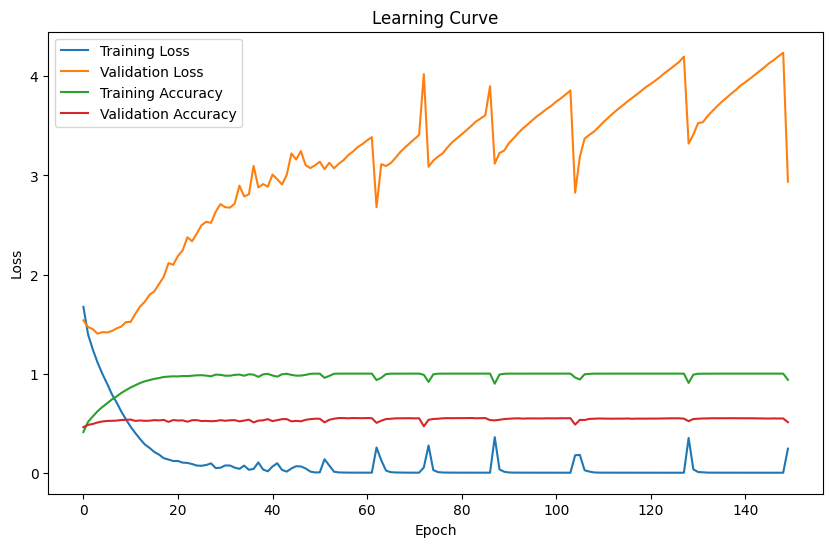

In [ ]:
# Build the TensorFlow model
model = Sequential([
    Dense(1024, activation='relu', input_shape=(3072,)),  # Input layer and first hidden layer
    Dense(512, activation='relu'),  # Second hidden layer
    Dense(256, activation='relu'),  # Third hidden layer
    Dense(10, activation='softmax')  # Output layer (10 classes for CIFAR-10)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# One-hot encoding for labels
y_train_sample_one_hot = to_categorical(y_train_sample, num_classes=10)
y_val_sample_one_hot = to_categorical(y_val_sample, num_classes=10)

# Train the model with early stopping
history = model.fit(X_train_sample, y_train_sample_one_hot,
                    epochs=150,
                    batch_size=128,
                    validation_data=(X_val_sample, y_val_sample_one_hot),
                    verbose=0)

# Store the training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Get the accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

From the plot above, we can easily see that the model is overfitting when the epochs >= 20. Let's apply dropout technique to prevent overfitting

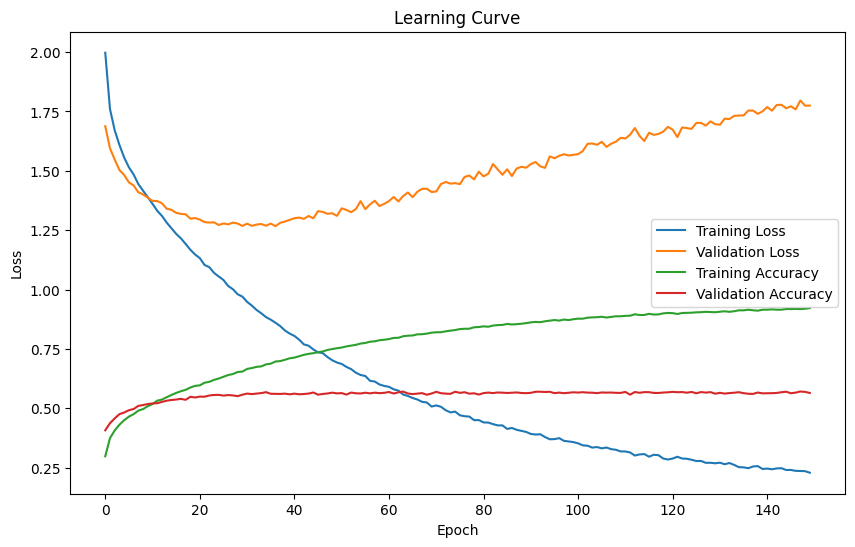

In [ ]:
# Import dropout
from tensorflow.keras.layers import Dropout

# Build the TensorFlow model
model = Sequential([
    Dense(1024, activation='relu', input_dim=3072),  # Input layer and first hidden layer
    Dropout(0.3),   # Dropout layer for regularization
    Dense(512, activation='relu'),  # Second hidden layer
    Dropout(0.3),   # Dropout layer for regularization
    Dense(256, activation='relu'),  # Third hidden layer
    Dropout(0.3),   # Dropout layer for regularization
    Dense(10, activation='softmax')  # Output layer (10 classes for CIFAR-10)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# One-hot encoding for labels
y_train_sample_one_hot = to_categorical(y_train_sample, num_classes=10)
y_val_sample_one_hot = to_categorical(y_val_sample, num_classes=10)

# Train the model with early stopping
history = model.fit(X_train_sample, y_train_sample_one_hot,
                    epochs=150,
                    batch_size=128,
                    validation_data=(X_val_sample, y_val_sample_one_hot),
                    verbose=0)

# Store the training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Store the val_acc and train_acc
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Since there is still overfitting. We need to use early stopping with max epochs = 30 to to prevent overfitting and this speed up the process. Let's try.

In [ ]:
# one hot encoding for labels
y_train_hot_encode = to_categorical(y_train, num_classes=10)
y_test_hot_encode = to_categorical(y_test, num_classes=10)

# early stopping
early_stopping = tff.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model:
model = Sequential([
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


history = model.fit(X_train_scale_flat, y_train_hot_encode,
                    epochs=30,
                    validation_split= 0.1,
                    callbacks=[early_stopping],
                    batch_size=128,
                    verbose=0)

# Print the train accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print(f"Train Accuracy: {train_accuracy:.4f}")

# Compute the test_acc
test_loss, test_acc = model.evaluate(X_test_scale_flat, y_test_hot_encode)
print(f"Test Accuracy: {test_acc:.4f}")



Train Accuracy: 0.6578
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5762 - loss: 1.2261
Test Accuracy: 0.5712


This model is okay.

Now, it's time to apply this model to others framworks and evaluate time, gpu usage.

### Final Models

**Import library for GPUs measurement**

In [5]:
!pip install GPUtil
import GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b968a64bdc70ebaf5f653e5d90e79003a66565c8d99bface30455d9683ebfd61
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [6]:
# Function to monitor GPU memory usage
def get_gpu_memory():
    gpus = GPUtil.getGPUs()
    if len(gpus) > 0:
        gpu = gpus[0]  # Assuming a single GPU setup
        return {
            "memory_used": gpu.memoryUsed,  # Memory used in MB
            "memory_total": gpu.memoryTotal,  # Total memory in MB
        }
    else:
        return {"memory_used": 0, "memory_total": 0}

#### TensorFlow

**Import modules**

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix


In [8]:
# Dictionary to store the result
results = {
    'framework': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'classification_matrix': [],
    'confusion_matrix': [],
    'elapsed_time': [],
    'memory_usage': []
}

# Measure GPUs and time
start_time = time.time()
initial_gpu_tf = get_gpu_memory()

# one hot encoding for labels
y_train_hot_encode = to_categorical(y_train, num_classes=10)
y_test_hot_encode = to_categorical(y_test, num_classes=10)

# early stopping
early_stopping = tff.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model:
model = Sequential([
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


history = model.fit(X_train_scale_flat, y_train_hot_encode,
                    epochs=30,
                    validation_split= 0.1,
                    callbacks=[early_stopping],
                    batch_size=128,
                    verbose=0)

# Print memory usage
final_gpu_tf = get_gpu_memory()
print(f"Memory used: {final_gpu_tf['memory_used'] - initial_gpu_tf['memory_used']} MB")
print(f"Memory total: {final_gpu_tf['memory_total']} MB")

# Stop timer
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f}s")

# Print the train accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print(f"Train Accuracy: {train_accuracy:.4f}")


# Compute the test_acc
test_loss, test_acc = model.evaluate(X_test_scale_flat, y_test_hot_encode)
print(f"Test Accuracy: {test_acc:.4f}")

# get classification matrix and confusion matrix
y_pred = model.predict(X_test_scale_flat)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_hot_encode, axis=1)
classification_mat = classification_report(y_test_classes, y_pred_classes)
confusion_mat = confusion_matrix(y_test_classes, y_pred_classes)
print(f"Classification Report:\n{classification_mat}")
print(f"Confusion Matrix:\n{confusion_mat}")

# Store result
results['framework'].append('TensorFlow')
results['train_accuracy'].append(train_accuracy)
results['val_accuracy'].append(test_acc)
results['classification_matrix'].append(classification_mat)
results['confusion_matrix'].append(confusion_mat)
results['elapsed_time'].append(elapsed_time)
results['memory_usage'].append({
    "memory_used": final_gpu_tf["memory_used"] - initial_gpu_tf["memory_used"],
    "memory_total": final_gpu_tf["memory_total"]
})

Memory used: 1157.0 MB
Memory total: 15360.0 MB
Elapsed time: 53.61s
Train Accuracy: 0.6596
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5687 - loss: 1.2341
Test Accuracy: 0.5645
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1000
           1       0.67      0.69      0.68      1000
           2       0.48      0.41      0.44      1000
           3       0.37      0.35      0.36      1000
           4       0.49      0.49      0.49      1000
           5       0.46      0.47      0.47      1000
           6       0.56      0.66      0.61      1000
           7       0.65      0.65      0.65      1000
           8       0.67      0.72      0.69      1000
           9       0.63      0.58      0.61      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56

**Save model for further using**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Remount with force
import os # Import os for directory creation

# Create directory, if it doesn't exist, using os.makedirs
os.makedirs('/content/drive/MyDrive/Final_Project', exist_ok=True)
model.save('/content/drive/MyDrive/Final_Project/tensorflow.h5')

Mounted at /content/drive


#### PyTorch

**Import modules**

In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

**Train model**

In [10]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing
y_train_torch = y_train.reshape(-1)
y_test_torch = y_test.reshape(-1)

# GPU usage and time
start_time = time.time()
initial_gpu_torch = get_gpu_memory()

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # 3 layers = [1024, 512, 256]
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
# convert data to torch.tensor
X_train_tensor = torch.tensor(X_train_scale_flat, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_torch, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scale_flat, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_torch, dtype=torch.long).to(device)

# tensor dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model, loss, optimizer
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early Stopping parameters
patience = 5  # Number of epochs with no improvement to wait before stopping
best_val_acc = 0.0
epochs_no_improve = 0  # Count of epochs with no improvement

# Training loop
for epoch in range(30):
    # set model to training mode
    model.train()
    # initialize loss for this epoch
    epoch_loss = 0.0
    # batchs loop
    for X_batch, y_batch in train_loader:
        # forward
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        # convert loss tensor and add to this epoch loss
        epoch_loss += loss.item()

    # early stopping logic
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        y_test_pred = torch.argmax(model(X_test_tensor), dim=1)
        test_acc = (y_test_pred == y_test_tensor).float().mean().item()

    # Check if the validation accuracy has improved
    if test_acc >= best_val_acc:
        best_val_acc = test_acc
        epochs_no_improve = 0  # Reset counter if improvement is seen
    else:
        epochs_no_improve += 1

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    # Train accuracy
    y_train_pred = torch.argmax(model(X_train_tensor), dim=1)
    train_acc = (y_train_pred == y_train_tensor).float().mean().item()
    print(f"Manual Train Accuracy: {train_acc:.4f}")

    # Test accuracy
    y_test_pred = torch.argmax(model(X_test_tensor), dim=1)
    test_acc = (y_test_pred == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {test_acc:.4f}")

# stop timer
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f}s")

# get memory usage
final_gpu_torch = get_gpu_memory()
print(f"Memory used: {final_gpu_torch['memory_used'] - initial_gpu_torch['memory_used']} MB")
print(f"Memory total: {final_gpu_torch['memory_total']} MB")

# get classification and confusion matrix
y_pred = model(X_test_tensor)
y_pred_classes = torch.argmax(y_pred, dim=1)
y_test_classes = y_test_tensor
classification_mat = classification_report(y_test_classes.cpu(), y_pred_classes.cpu())
confusion_mat = confusion_matrix(y_test_classes.cpu(), y_pred_classes.cpu())
print(f"Classification Report:\n{classification_mat}")
print(f"Confusion Matrix:\n{confusion_mat}")


# store result
results['framework'].append('PyTorch')
results['train_accuracy'].append(train_acc)
results['val_accuracy'].append(test_acc)
results['classification_matrix'].append(classification_mat)
results['confusion_matrix'].append(confusion_mat)
results['elapsed_time'].append(elapsed_time)
results['memory_usage'].append({
    "memory_used": final_gpu_torch["memory_used"] - initial_gpu_torch["memory_used"],
    "memory_total": final_gpu_torch["memory_total"]
})


Using device: cuda
Manual Train Accuracy: 0.8348
Test Accuracy: 0.5825
Elapsed time: 56.51s
Memory used: 1314.0 MB
Memory total: 15360.0 MB
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1000
           1       0.71      0.66      0.68      1000
           2       0.53      0.42      0.47      1000
           3       0.38      0.43      0.41      1000
           4       0.55      0.46      0.50      1000
           5       0.49      0.47      0.48      1000
           6       0.58      0.69      0.63      1000
           7       0.65      0.65      0.65      1000
           8       0.70      0.70      0.70      1000
           9       0.61      0.64      0.62      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000

Confusion Matrix:
[[700  20  47  16  23   8  32  11  94  49]
 [ 35 661  11  28

**Save model for further using**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Create directory in Google Drive if it doesn't exist
os.makedirs('/content/drive/MyDrive/Final_Project', exist_ok=True)

# Save the model parameters (state_dict) to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/Final_Project/pytorch.pth')


Mounted at /content/drive


#### Scikit-Learn

Since the MLPClassifier of Scikit-Learn framework doesn't support Dropout, and re-implementation of this model is really difficult for me. Therefore, I will just train the model without Dropout.

Here is a way to apply Dropout to MLPClassifier: [MLPClassifier With Dropout](https://datascience.stackexchange.com/questions/117082/how-can-i-implement-dropout-in-scikit-learn)



**Import modules**

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

**Train Model**

In [13]:
# GPU and time measure
start_time = time.time()
initial_gpu_sklearn = get_gpu_memory()


# define the model
model = MLPClassifier(
    hidden_layer_sizes=(1024, 512, 256),
    activation="relu",
    solver="adam",
    batch_size=128,
    learning_rate_init=0.0001,
    max_iter=30,  # epochs
    random_state=42,
    early_stopping=True,  # turn early stopping on
    n_iter_no_change=5,  # patience = 5
    validation_fraction=0.1,  # Set aside a validation set for early stopping
)

# Train the model
model.fit(X_train_scale_flat, y_train.ravel())  # Ravel y_train to a 1D array

# Evaluate
train_acc = model.score(X_train_scale_flat, y_train)
test_acc = model.score(X_test_scale_flat, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


# get gpu usage
final_gpu_sklearn = get_gpu_memory()
print(f"Memory used: {final_gpu_sklearn['memory_used'] - initial_gpu_sklearn['memory_used']} MB")

# stop timer
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f}s")

# get classification and confusion matrix
y_pred = model.predict(X_test_scale_flat)
classification_mat = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print(f"Classification Report:\n{classification_mat}")
print(f"Confusion Matrix:\n{confusion_mat}")

# Store result
results['framework'].append('Scikit-Learn')
results['train_accuracy'].append(train_acc)
results['val_accuracy'].append(test_acc)
results['classification_matrix'].append(classification_mat)
results['confusion_matrix'].append(confusion_mat)
results['elapsed_time'].append(elapsed_time)
results['memory_usage'].append({
    "memory_used": final_gpu_sklearn["memory_used"] - initial_gpu_sklearn["memory_used"],
    "memory_total": final_gpu_sklearn["memory_total"]
})

Train Accuracy: 0.8240
Test Accuracy: 0.5408
Memory used: 0.0 MB
Elapsed time: 816.16s
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      1000
           1       0.61      0.66      0.63      1000
           2       0.44      0.43      0.43      1000
           3       0.36      0.35      0.36      1000
           4       0.46      0.45      0.45      1000
           5       0.50      0.43      0.46      1000
           6       0.54      0.61      0.57      1000
           7       0.61      0.60      0.60      1000
           8       0.66      0.69      0.67      1000
           9       0.58      0.54      0.56      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000

Confusion Matrix:
[[659  30  60  24  23   8  25  20 114  37]
 [ 35 660  18  17  15  13  23  22  71 126]
 [ 79  21 427  89 134  64  

**Save model for further using**

In [ ]:
from joblib import dump

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Create directory in Google Drive if it doesn't exist
os.makedirs('/content/drive/MyDrive/Final_Project', exist_ok=True)

# Save the Scikit-learn model using joblib
dump(model, '/content/drive/MyDrive/Final_Project/scikit_learn.joblib')

Mounted at /content/drive


['/content/drive/MyDrive/Final_Project/scikit_learn.joblib']

#### JAX (with Flax)

**Import modules**

In [14]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from sklearn.metrics import classification_report, confusion_matrix

**Train Model**

In [18]:
# Ensure we're using GPU if available
device = jax.devices("gpu")[0] if jax.devices("gpu") else jax.devices("cpu")[0]
print(f"Using device: {device}")

# Training loop with early stopping based on cross-entropy loss
start_time = time.time()
initial_gpu_jax = get_gpu_memory()

# Initialize JAX random seed
key = jax.random.PRNGKey(42)

# Define the MLP model using Flax with Dropout
class MLP(nn.Module):
    hidden_layer_sizes: tuple
    dropout_rate: float = 0.3  # Dropout rate
    activation: callable = nn.relu

    def setup(self):
        self.hidden_layers = [
            nn.Dense(size) for size in self.hidden_layer_sizes
        ]
        self.output_layer = nn.Dense(10)  # Output layer for 10 classes
        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, *, train: bool):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x, deterministic=not train)
        x = self.output_layer(x)
        return x

# Define the cross-entropy loss function (error metric)
def cross_entropy_loss(logits, labels):
    return -jnp.mean(jnp.sum(labels * jax.nn.log_softmax(logits), axis=-1))

# Define the accuracy metric
def accuracy(logits, labels):
    pred = jnp.argmax(logits, axis=-1)
    true = jnp.argmax(labels, axis=-1)
    return jnp.mean(pred == true)

# Prepare data (ensure data is on the GPU)
X_train_flat = jnp.array(X_train_scale_flat)  # Convert to JAX array
y_train_one_hot = jax.nn.one_hot(y_train.ravel(), 10)  # One-hot encoding for labels
X_test_flat = jnp.array(X_test_scale_flat)
y_test_one_hot = jax.nn.one_hot(y_test.ravel(), 10)

# Move data to the GPU
X_train_flat = jax.device_put(X_train_flat, device)
y_train_one_hot = jax.device_put(y_train_one_hot, device)
X_test_flat = jax.device_put(X_test_flat, device)
y_test_one_hot = jax.device_put(y_test_one_hot, device)

# Initialize the model
model = MLP(hidden_layer_sizes=(1024, 512, 256), dropout_rate=0.3)
params = model.init(key, X_train_flat[:1], train=True)  # Initialize parameters with a dummy input

# Move model parameters to GPU
params = jax.device_put(params, device)

# Define the optimizer
optimizer = optax.adam(learning_rate=0.0001)
opt_state = optimizer.init(params)

# Define training step
@jax.jit
def train_step(params, opt_state, batch, key):
    X_batch, y_batch = batch

    def loss_fn(params):
        logits = model.apply(params, X_batch, train=True, rngs={"dropout": key})
        loss = cross_entropy_loss(logits, y_batch)
        return loss

    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_fn(params)

# Validation step (to calculate validation loss)
@jax.jit
def val_step(params, X_val, y_val):
    logits_val = model.apply(params, X_val, train=False)
    return cross_entropy_loss(logits_val, y_val)

best_val_loss = float("inf")
patience = 5  # Number of epochs to wait for improvement in validation loss
patience_counter = 0

for epoch in range(30):
    # Training loop
    for i in range(0, len(X_train_flat), 128):  # Using batch size of 128
        X_batch = X_train_flat[i:i+128]
        y_batch = y_train_one_hot[i:i+128]
        key, subkey = jax.random.split(key)
        params, opt_state, loss = train_step(params, opt_state, (X_batch, y_batch), subkey)

    # Validation step: Calculate validation loss
    val_loss = val_step(params, X_test_flat, y_test_one_hot)
    print(f"Epoch {epoch+1}, Validation Loss (Cross-Entropy): {val_loss:.4f}")

    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Final evaluation
logits_train = model.apply(params, X_train_flat, train=False)
logits_test = model.apply(params, X_test_flat, train=False)
train_acc = accuracy(logits_train, y_train_one_hot)
test_acc = accuracy(logits_test, y_test_one_hot)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get classification and confusion matrix
y_pred = jnp.argmax(logits_test, axis=-1)
classification_mat = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print(f"Classification Report:\n{classification_mat}")
print(f"Confusion Matrix:\n{confusion_mat}")

# Get GPU memory usage (assumes `get_gpu_memory` is a custom function)
final_gpu_jax = get_gpu_memory()
print(f"Memory used: {final_gpu_jax['memory_used'] - initial_gpu_jax['memory_used']} MB")

# Stop timer
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f}s")

# Store result
results["framework"].append("JAX")
results["train_accuracy"].append(train_acc)
results["val_accuracy"].append(test_acc)
results["classification_matrix"].append(classification_mat)
results["confusion_matrix"].append(confusion_mat)
results["elapsed_time"].append(elapsed_time)
results["memory_usage"].append(
    {
        "memory_used": final_gpu_jax["memory_used"] - initial_gpu_jax["memory_used"],
        "memory_total": final_gpu_jax["memory_total"],
    }
)


Using device: cuda:0
Epoch 1, Validation Loss (Cross-Entropy): 1.6019
Epoch 2, Validation Loss (Cross-Entropy): 1.5086
Epoch 3, Validation Loss (Cross-Entropy): 1.4520
Epoch 4, Validation Loss (Cross-Entropy): 1.4123
Epoch 5, Validation Loss (Cross-Entropy): 1.3900
Epoch 6, Validation Loss (Cross-Entropy): 1.3677
Epoch 7, Validation Loss (Cross-Entropy): 1.3423
Epoch 8, Validation Loss (Cross-Entropy): 1.3247
Epoch 9, Validation Loss (Cross-Entropy): 1.3112
Epoch 10, Validation Loss (Cross-Entropy): 1.3024
Epoch 11, Validation Loss (Cross-Entropy): 1.2908
Epoch 12, Validation Loss (Cross-Entropy): 1.2773
Epoch 13, Validation Loss (Cross-Entropy): 1.2726
Epoch 14, Validation Loss (Cross-Entropy): 1.2630
Epoch 15, Validation Loss (Cross-Entropy): 1.2564
Epoch 16, Validation Loss (Cross-Entropy): 1.2497
Epoch 17, Validation Loss (Cross-Entropy): 1.2448
Epoch 18, Validation Loss (Cross-Entropy): 1.2417
Epoch 19, Validation Loss (Cross-Entropy): 1.2404
Epoch 20, Validation Loss (Cross-Entro

### Evaluation

**Print out the final result**

In [19]:
final_results_df = pd.DataFrame(results)
final_results_df


,framework,train_accuracy,val_accuracy,classification_matrix,confusion_matrix,elapsed_time,memory_usage
0,TensorFlow,0.659556,0.5645,precision recall f1-score ...,"[[634, 31, 48, 26, 27, 14, 36, 16, 122, 46], [...",53.612685,"{'memory_used': 1157.0, 'memory_total': 15360.0}"
1,PyTorch,0.83484,0.5825,precision recall f1-score ...,"[[700, 20, 47, 16, 23, 8, 32, 11, 94, 49], [35...",56.510426,"{'memory_used': 1314.0, 'memory_total': 15360.0}"
2,Scikit-Learn,0.82402,0.5408,precision recall f1-score ...,"[[659, 30, 60, 24, 23, 8, 25, 20, 114, 37], [3...",816.159138,"{'memory_used': 0.0, 'memory_total': 15360.0}"
3,JAX,0.78274,0.5711,precision recall f1-score ...,"[[654, 23, 48, 13, 24, 17, 25, 25, 120, 51], [...",34.322663,"{'memory_used': 10.0, 'memory_total': 15360.0}"


#### Training & Test Accuracy

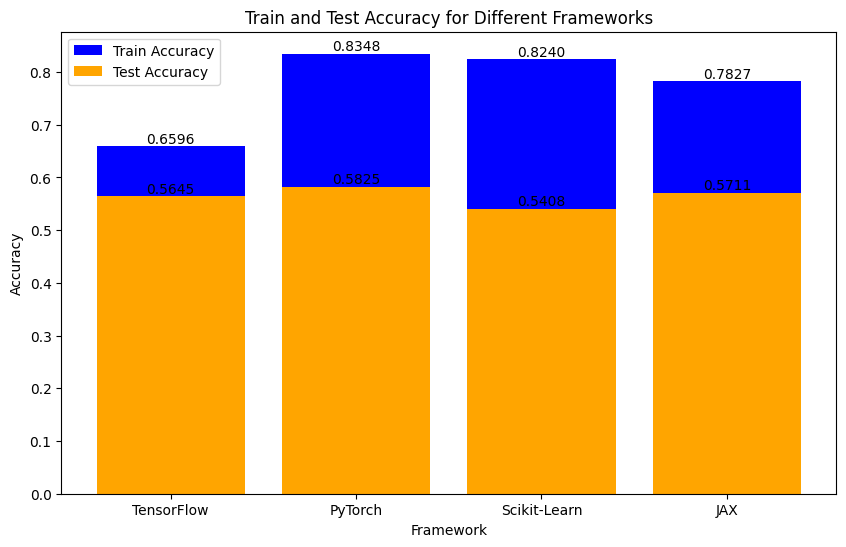

In [26]:
from typing_extensions import final
train_accs, test_accs = results['train_accuracy'], results['val_accuracy']
frameworks = results['framework']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(frameworks, train_accs, label='Train Accuracy', color='blue')
plt.bar(frameworks, test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Framework')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy for Different Frameworks')
for i, (train_acc, test_acc) in enumerate(zip(train_accs, test_accs)):
    plt.text(i, train_acc, f'{train_acc:.4f}', ha='center', va='bottom')
    plt.text(i, test_acc, f'{test_acc:.4f}', ha='center', va='bottom')
plt.legend()
plt.show()



Summary:
- PyTorch: has the highest train accuracy and test accuracy, but the gap between 2 accuracy is quite large suggest PyTorch framework can be overfitting on this model.
- TensorFlow: has the worst train accuracy, but got an average test accuracy and the gap between 2 accuracy is the best suggest this model is most balance. This mean this model is okay but not good.
- Scikit-Learn: has 2nd best train accuracy but also has the worst test accuracy. This mean this model is overfitting.
- JAX: has good accuracy on both train and test dataset but not the best.

#### Classification matrix & Classification report

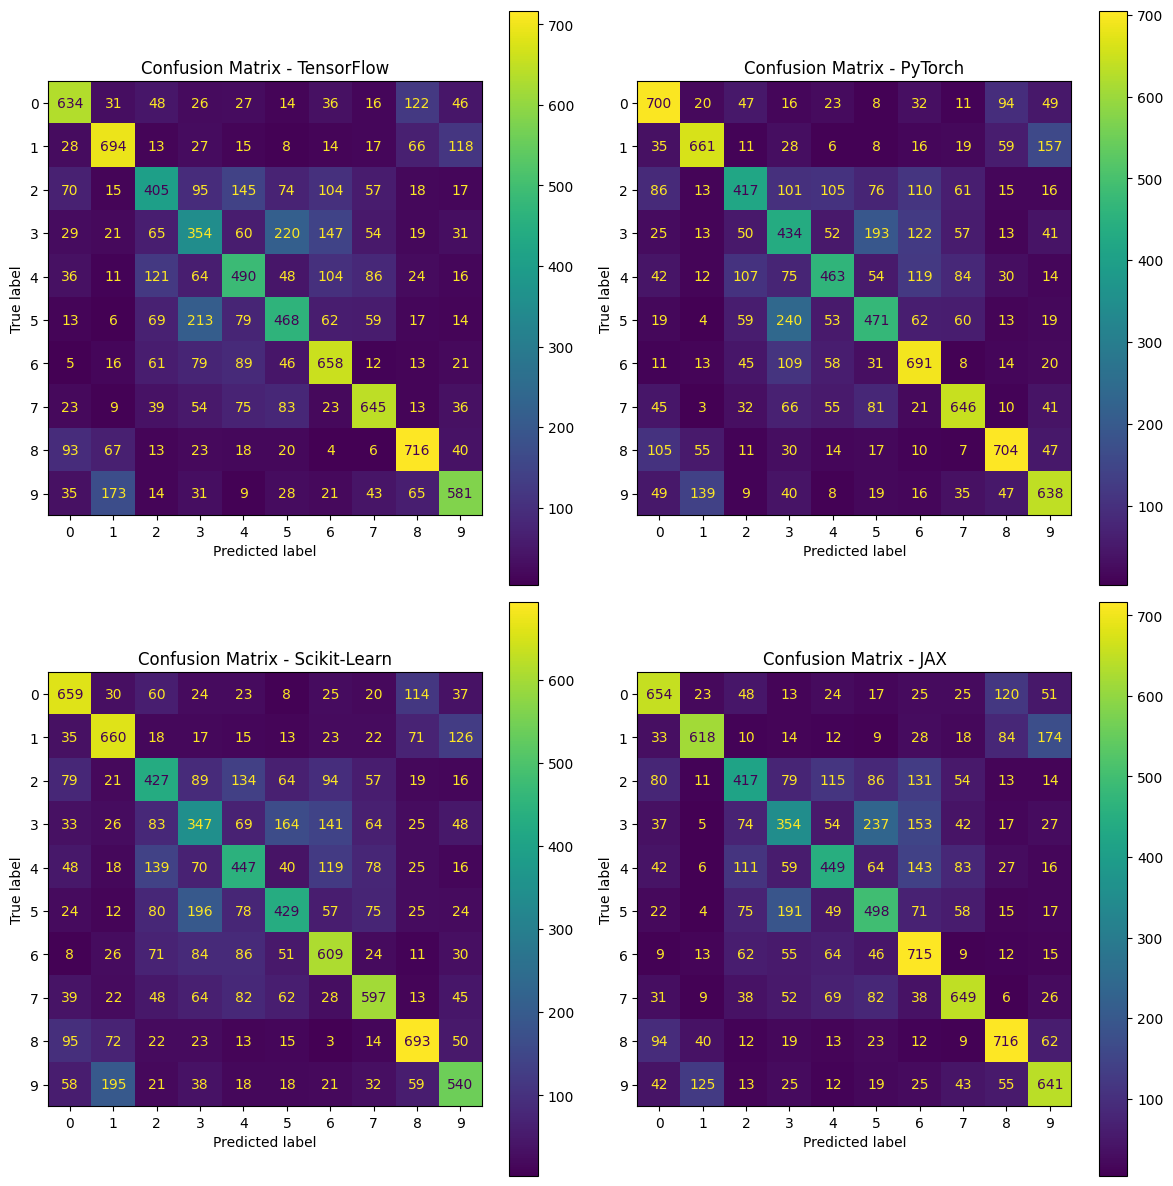

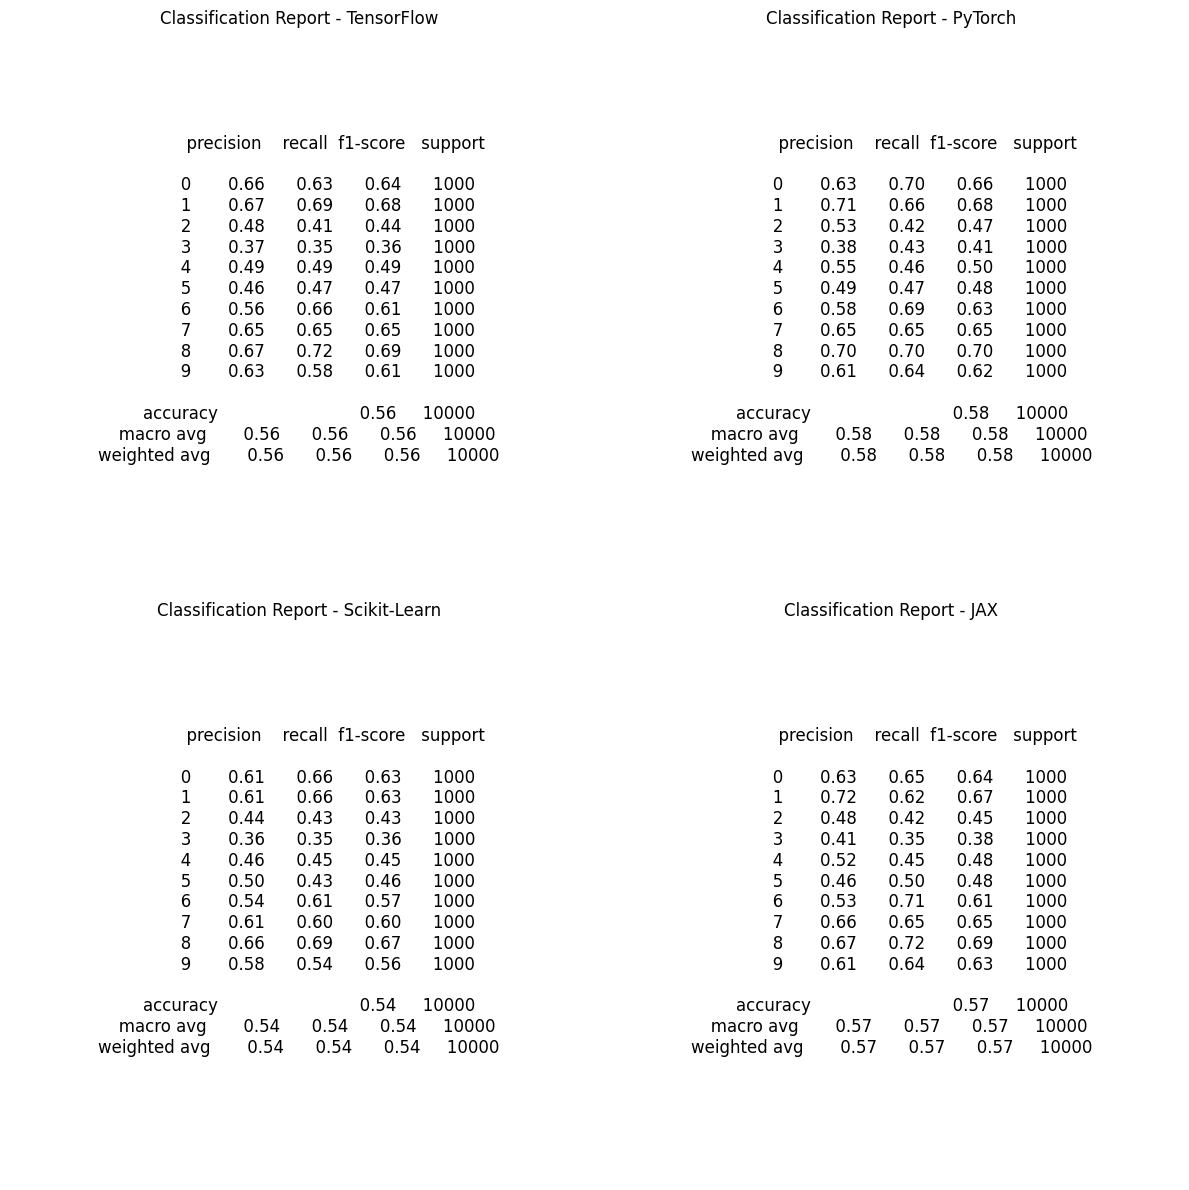

In [35]:
# classification display module
from sklearn.metrics import ConfusionMatrixDisplay

# get classification metrics
confusion_metrics = results['confusion_matrix']
cm_tensorflow = confusion_metrics[0]
cm_pytorch = confusion_metrics[1]
cm_sklearn = confusion_metrics[2]
cm_jax = confusion_metrics[3]

# class names
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a 2x2 subplot for displaying confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# TensorFlow Confusion Matrix
disp_tf = ConfusionMatrixDisplay(confusion_matrix=cm_tensorflow, display_labels=class_names)
disp_tf.plot(ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title("Confusion Matrix - TensorFlow")

# PyTorch Confusion Matrix
disp_pt = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=class_names)
disp_pt.plot(ax=axs[0, 1], cmap='viridis')
axs[0, 1].set_title("Confusion Matrix - PyTorch")

# Scikit-Learn Confusion Matrix
disp_sklearn = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=class_names)
disp_sklearn.plot(ax=axs[1, 0], cmap='viridis')
axs[1, 0].set_title("Confusion Matrix - Scikit-Learn")

# JAX Confusion Matrix
disp_jax = ConfusionMatrixDisplay(confusion_matrix=cm_jax, display_labels=class_names)
disp_jax.plot(ax=axs[1, 1], cmap='viridis')
axs[1, 1].set_title("Confusion Matrix - JAX")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Assuming results['classification_matrix'] contains classification reports as strings
report_tf = results['classification_matrix'][0]
report_pt = results['classification_matrix'][1]
report_sklearn = results['classification_matrix'][2]
report_jax = results['classification_matrix'][3]

# Create 2x2 subplot for classification reports
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# TensorFlow Classification Report
axs[0, 0].text(0.5, 0.5, report_tf, ha='center', va='center', fontsize=12, wrap=True)
axs[0, 0].axis('off')
axs[0, 0].set_title("Classification Report - TensorFlow")

# PyTorch Classification Report
axs[0, 1].text(0.5, 0.5, report_pt, ha='center', va='center', fontsize=12, wrap=True)
axs[0, 1].axis('off')
axs[0, 1].set_title("Classification Report - PyTorch")

# Scikit-Learn Classification Report
axs[1, 0].text(0.5, 0.5, report_sklearn, ha='center', va='center', fontsize=12, wrap=True)
axs[1, 0].axis('off')
axs[1, 0].set_title("Classification Report - Scikit-Learn")

# JAX Classification Report
axs[1, 1].text(0.5, 0.5, report_jax, ha='center', va='center', fontsize=12, wrap=True)
axs[1, 1].axis('off')
axs[1, 1].set_title("Classification Report - JAX")

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Here's names for each label:

In [36]:
print("\nCIFAR-10 Class Names:")
for idx, name in enumerate(label_names):
    print(f"{idx}: {name}")


CIFAR-10 Class Names:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


From the information we get above, we can easily see that:
- Labels 0, 1, 6, 7, 8, 9:
  - These labels are predicted well.
  - Especially, label 8 always has the best accuracy
  - Besides, label 6 is predicted well but the gap between precision and recall sometimes is quite large (~0.1)
- Labels 2, 3, 4, 5:
  - Usually performed poorly by all frameworks. Especially with label 3.
  - Labels 2, 4, 5 sometimes get to be imbalanced
